In [20]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, TwoSlopeNorm
import os

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## 1. Configuration and Data Paths

Set up paths to:
- **Profiles**: Stacked density profiles from DMO and Hydro
- **Statistics**: Halo statistics (masses, baryon fractions, etc.)
- **Maps**: 2D projected density fields (DMO, Hydro, Replace)
- **Lensplanes** (optional): For convergence power spectrum analysis

In [21]:
# ============================================================================
# CONFIGURATION - FILL IN YOUR PATHS
# ============================================================================

# Base output directory from generate_all_unified.py
OUTPUT_BASE = '/mnt/home/mlee1/ceph/hydro_replace_fields'
SIM_LABEL = 'L205n2500TNG'  # or 'L205n1250TNG', 'L205n625TNG'

OUTPUT_DIR = os.path.join(OUTPUT_BASE, SIM_LABEL)

# Snapshot to analyze
SNAP = 96  # z ~ 0

# Box size (Mpc/h)
BOX_SIZE = 205.0

# Mass bin edges (log10 Msun/h)
MASS_BIN_EDGES = [12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 16.0]

# Radial bins (in units of R200)
RADIAL_BINS = np.logspace(-2, np.log10(5), 31)  # 0.01 to 5 R200

print(f"Output directory: {OUTPUT_DIR}")
print(f"Snapshot: {SNAP}")
print(f"Mass bins: {MASS_BIN_EDGES}")

Output directory: /mnt/home/mlee1/ceph/hydro_replace_fields/L205n2500TNG
Snapshot: 96
Mass bins: [12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 16.0]


## 2. Load Profile Data

Load the stacked density profiles from the HDF5 file generated by `generate_all_unified.py`.

Available datasets:
- `stacked_dmo`: DMO density profiles per mass bin
- `stacked_hydro`: Hydro total density profiles per mass bin
- `stacked_hydro_dm`, `stacked_hydro_gas`, `stacked_hydro_stars`: By particle type

In [22]:
# Load profile data
profile_file = os.path.join(OUTPUT_DIR, 'profiles', f'profiles_snap{SNAP:03d}.h5')

print(f"Loading: {profile_file}")

with h5py.File(profile_file, 'r') as f:
    # Attributes
    radial_bins = f.attrs['radial_bins']
    mass_bin_edges = f.attrs['mass_bin_edges']
    
    # Stacked profiles (shape: n_mass_bins x n_radial_bins)
    stacked_dmo = f['stacked_dmo'][:]
    stacked_hydro = f['stacked_hydro'][:]
    stacked_hydro_dm = f['stacked_hydro_dm'][:]
    stacked_hydro_gas = f['stacked_hydro_gas'][:]
    stacked_hydro_stars = f['stacked_hydro_stars'][:]
    
    counts_dmo = f['counts_dmo'][:]
    counts_hydro = f['counts_hydro'][:]

# Compute radial bin centers (geometric mean)
r_centers = np.sqrt(radial_bins[:-1] * radial_bins[1:])
n_mass_bins = len(mass_bin_edges) - 1
n_radial_bins = len(r_centers)

print(f"\nLoaded profiles:")
print(f"  Mass bins: {n_mass_bins}")
print(f"  Radial bins: {n_radial_bins}")
print(f"  Radial range: {r_centers[0]:.3f} - {r_centers[-1]:.2f} R200")

Loading: /mnt/home/mlee1/ceph/hydro_replace_fields/L205n2500TNG/profiles/profiles_snap096.h5

Loaded profiles:
  Mass bins: 6
  Radial bins: 30
  Radial range: 0.011 - 4.51 R200


## 3. Load Halo Statistics

Load per-halo statistics including:
- Halo masses and positions
- Baryon fractions at multiple radii
- Mass conservation ratios (Hydro/DMO)

In [23]:
# Load statistics
stats_file = os.path.join(OUTPUT_DIR, 'analysis', f'halo_statistics_snap{SNAP:03d}.h5')

print(f"Loading: {stats_file}")

with h5py.File(stats_file, 'r') as f:
    # Per-halo properties
    log_masses = f['log_masses'][:]  # log10(M200c / Msun/h)
    radii_r200 = f.attrs['radii_r200']  # [0.5, 1.0, 2.0, 3.0, 4.0, 5.0]
    
    # Baryon fractions at each radius (shape: n_halos x n_radii)
    f_baryon = f['f_baryon'][:]
    f_gas = f['f_gas'][:]
    f_stellar = f['f_stellar'][:]
    
    # Masses
    m_total = f['m_total'][:]  # Total mass in Hydro
    m_dmo = f['m_dmo'][:]      # Total mass in DMO
    
    # Mass conservation
    ratio_total = f['ratio_total'][:]  # m_total / m_dmo
    ratio_dm = f['ratio_dm'][:]        # m_dm_hydro / m_dmo

n_halos = len(log_masses)
print(f"\nLoaded statistics for {n_halos} halos")
print(f"Mass range: 10^{log_masses.min():.2f} - 10^{log_masses.max():.2f} Msun/h")
print(f"Radii measured: {radii_r200} R200")

Loading: /mnt/home/mlee1/ceph/hydro_replace_fields/L205n2500TNG/analysis/halo_statistics_snap096.h5

Loaded statistics for 28375 halos
Mass range: 10^12.00 - 10^14.98 Msun/h
Radii measured: [0.5 1.  2.  3.  4.  5. ] R200


## 4. Visualize DMO vs Hydro Profiles

Before computing the response formalism, let's visualize the raw baryonic effects:
- How do profiles differ between DMO and Hydro?
- Where is mass depleted (cores) vs enhanced (outskirts)?

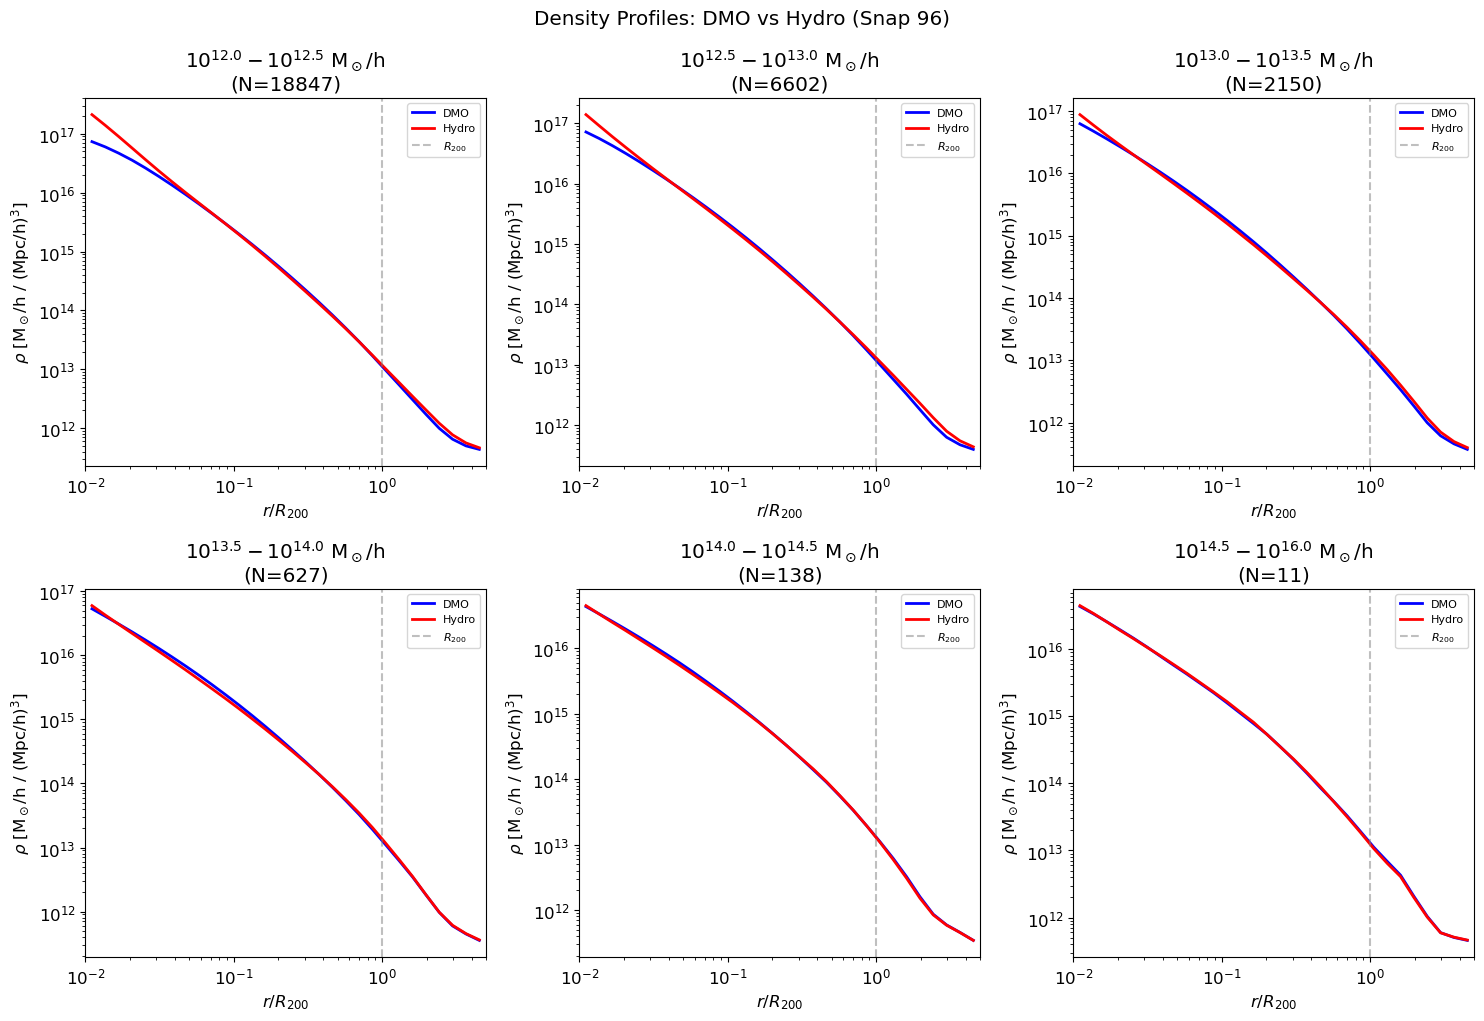

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

mass_labels = [f'$10^{{{mass_bin_edges[i]:.1f}}} - 10^{{{mass_bin_edges[i+1]:.1f}}}$ M$_\odot$/h' 
               for i in range(n_mass_bins)]

for i in range(min(n_mass_bins, 6)):
    ax = axes.flat[i]
    
    # Normalize by number of halos in bin
    n_in_bin = np.sum((log_masses >= mass_bin_edges[i]) & (log_masses < mass_bin_edges[i+1]))
    
    if n_in_bin > 0:
        dmo_avg = stacked_dmo[i] / n_in_bin
        hydro_avg = stacked_hydro[i] / n_in_bin
        
        ax.loglog(r_centers, dmo_avg, 'b-', lw=2, label='DMO')
        ax.loglog(r_centers, hydro_avg, 'r-', lw=2, label='Hydro')
        ax.axvline(1.0, color='gray', ls='--', alpha=0.5, label='$R_{200}$')
    
    ax.set_xlabel('$r / R_{200}$')
    ax.set_ylabel('$\\rho$ [M$_\odot$/h / (Mpc/h)$^3$]')
    ax.set_title(f'{mass_labels[i]}\n(N={n_in_bin})')
    ax.legend(fontsize=8)
    ax.set_xlim(0.01, 5)

plt.tight_layout()
plt.suptitle(f'Density Profiles: DMO vs Hydro (Snap {SNAP})', y=1.02)
plt.show()

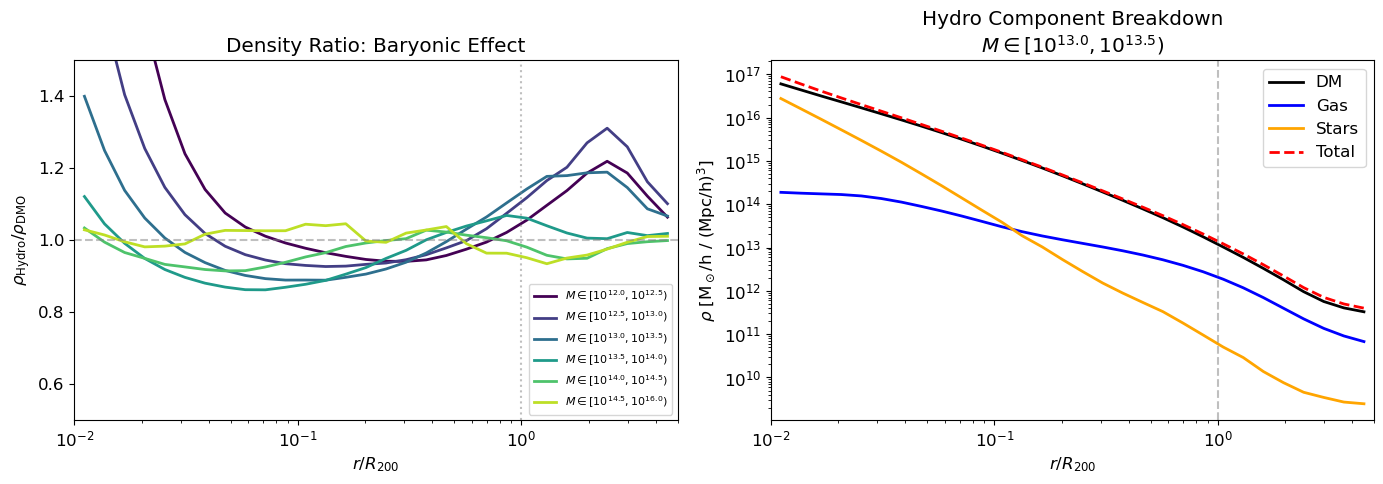

In [25]:
# Plot the ratio Hydro/DMO to see suppression/enhancement
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = plt.cm.viridis(np.linspace(0, 0.9, n_mass_bins))

ax = axes[0]
for i in range(n_mass_bins):
    n_in_bin = np.sum((log_masses >= mass_bin_edges[i]) & (log_masses < mass_bin_edges[i+1]))
    if n_in_bin > 0:
        ratio = stacked_hydro[i] / np.where(stacked_dmo[i] > 0, stacked_dmo[i], 1)
        ax.semilogx(r_centers, ratio, color=colors[i], lw=2, 
                   label=f'$M \in [10^{{{mass_bin_edges[i]:.1f}}}, 10^{{{mass_bin_edges[i+1]:.1f}}})$')

ax.axhline(1.0, color='gray', ls='--', alpha=0.5)
ax.axvline(1.0, color='gray', ls=':', alpha=0.5)
ax.set_xlabel('$r / R_{200}$')
ax.set_ylabel('$\\rho_{\\rm Hydro} / \\rho_{\\rm DMO}$')
ax.set_title('Density Ratio: Baryonic Effect')
ax.legend(fontsize=8, loc='lower right')
ax.set_xlim(0.01, 5)
ax.set_ylim(0.5, 1.5)

# Hydro component breakdown
ax = axes[1]
i_example = 2  # Choose a mass bin to show breakdown
n_in_bin = np.sum((log_masses >= mass_bin_edges[i_example]) & (log_masses < mass_bin_edges[i_example+1]))
if n_in_bin > 0:
    ax.loglog(r_centers, stacked_hydro_dm[i_example]/n_in_bin, 'k-', lw=2, label='DM')
    ax.loglog(r_centers, stacked_hydro_gas[i_example]/n_in_bin, 'b-', lw=2, label='Gas')
    ax.loglog(r_centers, stacked_hydro_stars[i_example]/n_in_bin, 'orange', lw=2, label='Stars')
    ax.loglog(r_centers, stacked_hydro[i_example]/n_in_bin, 'r--', lw=2, label='Total')
    ax.axvline(1.0, color='gray', ls='--', alpha=0.5)

ax.set_xlabel('$r / R_{200}$')
ax.set_ylabel('$\\rho$ [M$_\odot$/h / (Mpc/h)$^3$]')
ax.set_title(f'Hydro Component Breakdown\n$M \in [10^{{{mass_bin_edges[i_example]:.1f}}}, 10^{{{mass_bin_edges[i_example+1]:.1f}}})$')
ax.legend()
ax.set_xlim(0.01, 5)

plt.tight_layout()
plt.show()

---
## 5. The Replace Field Construction

From the formalism (Eq. 1):

$$
\rho_{\rm R}(\mathbf{x},z; M_{\min},\alpha)
=
\rho_{\rm D}(\mathbf{x},z)
+
\sum_{i \in \mathcal{H}(M_{\min},z)}
\Bigl[
\rho_{\rm H,halo}^{(i)}(\mathbf{x};\alpha)
-
\rho_{\rm D,halo}^{(i)}(\mathbf{x};\alpha)
\Bigr]
$$

For each halo above $M_{\min}$, we:
1. **Subtract** its DMO contribution within $\alpha R_{200}$
2. **Add** its Hydro contribution within the same region

### Using Profile Data
Instead of working with 3D fields directly, we can use the **stacked profiles** to compute an effective "Replace" profile for each mass bin and radius cut.

In [26]:
def compute_replace_profile(stacked_dmo, stacked_hydro, r_centers, alpha_cut):
    """
    Compute the Replace profile by swapping DMO -> Hydro within alpha*R200.
    
    For r < alpha: use Hydro profile
    For r >= alpha: use DMO profile
    
    Parameters
    ----------
    stacked_dmo : array (n_mass_bins, n_radial_bins)
        Stacked DMO density profiles
    stacked_hydro : array (n_mass_bins, n_radial_bins)
        Stacked Hydro density profiles  
    r_centers : array (n_radial_bins,)
        Radial bin centers in units of R200
    alpha_cut : float
        Replacement radius in units of R200
    
    Returns
    -------
    stacked_replace : array (n_mass_bins, n_radial_bins)
        Stacked Replace density profiles
    """
    stacked_replace = stacked_dmo.copy()
    
    # Mask for radii within the replacement region
    inner_mask = r_centers < alpha_cut
    
    # Replace inner region with Hydro
    stacked_replace[:, inner_mask] = stacked_hydro[:, inner_mask]
    
    return stacked_replace

# Test for alpha = 1.0
alpha_test = 1.0
stacked_replace_test = compute_replace_profile(stacked_dmo, stacked_hydro, r_centers, alpha_test)

print(f"Replace profile computed for alpha = {alpha_test}")
print(f"Shape: {stacked_replace_test.shape}")

Replace profile computed for alpha = 1.0
Shape: (6, 30)


---
## 6. Observable: Integrated Mass within Radius

As a simple observable $S$, let's use the **integrated mass within a given radius** from the profiles:

$$
M(<r) = \int_0^r 4\pi r'^2 \rho(r') dr'
$$

This can be computed from the binned profiles.

In [27]:
def compute_enclosed_mass(density_profile, r_centers, radial_bins):
    """
    Compute cumulative enclosed mass from density profile.
    
    Parameters
    ----------
    density_profile : array (n_radial_bins,)
        Density in each radial bin
    r_centers : array (n_radial_bins,)
        Radial bin centers (units of R200, so need to scale)
    radial_bins : array (n_radial_bins + 1,)
        Radial bin edges
    
    Returns
    -------
    enclosed_mass : array (n_radial_bins,)
        Cumulative mass within each bin edge
    """
    # Shell volumes (assuming R200 = 1 for normalized coordinates)
    volumes = 4/3 * np.pi * (radial_bins[1:]**3 - radial_bins[:-1]**3)
    
    # Mass in each shell
    shell_mass = density_profile * volumes
    
    # Cumulative sum
    enclosed_mass = np.cumsum(shell_mass)
    
    return enclosed_mass

# Compute enclosed mass for each mass bin
# Note: Need to normalize profiles first
print("Computing enclosed mass profiles...")

Computing enclosed mass profiles...


---
## 7. Define the Response Fraction $F_S$

From the formalism (Eq. 2):

$$
F_S(M_{\min}, \alpha)
\equiv
\frac{S_{\rm R}(M_{\min},\alpha) - S_{\rm D}}
{S_{\rm H} - S_{\rm D}}
$$

**Physical interpretation:**
- $F_S = 0$: Replace = DMO (no baryonic effect captured)
- $F_S = 1$: Replace = Hydro (full baryonic effect captured)
- $0 < F_S < 1$: partial recovery

$F_S(M_{\min}, \alpha)$ is a **cumulative distribution function** showing what fraction of the total baryonic effect comes from halos above $M_{\min}$ within $\alpha R_{200}$.

In [28]:
def compute_response_fraction(S_replace, S_dmo, S_hydro):
    """
    Compute the response fraction F_S.
    
    F_S = (S_R - S_D) / (S_H - S_D)
    
    Parameters
    ----------
    S_replace : float or array
        Observable from Replace field
    S_dmo : float or array
        Observable from DMO field
    S_hydro : float or array
        Observable from Hydro field
    
    Returns
    -------
    F_S : float or array
        Response fraction (0 = DMO, 1 = Hydro)
    """
    denominator = S_hydro - S_dmo
    
    # Avoid division by zero
    F_S = np.where(
        np.abs(denominator) > 1e-10,
        (S_replace - S_dmo) / denominator,
        0.0
    )
    
    return F_S

print("Response fraction function defined.")

Response fraction function defined.


---
## 8. Compute $F_S$ on a Grid of $(M_{\min}, \alpha)$

We'll compute the response fraction for:
- Multiple mass thresholds $M_{\min}$
- Multiple radius factors $\alpha$

Using the profile data as our observable.

In [29]:
# Define the (M_min, alpha) grid
M_min_grid = np.array([12.0, 12.5, 13.0, 13.5, 14.0])  # log10(M/Msun/h)
alpha_grid = np.array([0.5, 1.0, 1.5, 2.0, 3.0, 5.0])  # in units of R200

print(f"M_min grid: {M_min_grid}")
print(f"alpha grid: {alpha_grid}")
print(f"Total configurations: {len(M_min_grid)} x {len(alpha_grid)} = {len(M_min_grid) * len(alpha_grid)}")

M_min grid: [12.  12.5 13.  13.5 14. ]
alpha grid: [0.5 1.  1.5 2.  3.  5. ]
Total configurations: 5 x 6 = 30


In [33]:
def compute_replace_profile_with_mmin(stacked_dmo, stacked_hydro, r_centers, alpha_cut, mass_bin_edges, M_min_cut):
    """
    Compute Replace profile with mass threshold.
    
    For halos ABOVE M_min: use Hydro within alpha, DMO outside
    For halos BELOW M_min: use DMO everywhere (no replacement)
    """
    stacked_replace = stacked_dmo.copy()
    
    inner_mask = r_centers < alpha_cut
    
    for i in range(len(mass_bin_edges) - 1):
        bin_center = (mass_bin_edges[i] + mass_bin_edges[i+1]) / 2
        if bin_center >= M_min_cut:
            # This mass bin gets replaced
            stacked_replace[i, inner_mask] = stacked_hydro[i, inner_mask]
        # else: keep as DMO (already copied)
    
    return stacked_replace


# Compute F_S grid
F_S_grid = np.zeros((len(M_min_grid), len(alpha_grid), n_radial_bins))

for i, M_min in enumerate(M_min_grid):
    for j, alpha in enumerate(alpha_grid):
        # Get total DMO and Hydro profiles (sum ALL bins - this is the "true" field)
        dmo_profile = np.sum(stacked_dmo, axis=0)
        hydro_profile = np.sum(stacked_hydro, axis=0)
        
        # Compute Replace profile with M_min cut
        replace_stacked = compute_replace_profile_with_mmin(
            stacked_dmo, stacked_hydro, r_centers, alpha, mass_bin_edges, M_min
        )
        replace_profile = np.sum(replace_stacked, axis=0)
        
        # Compute response fraction
        F_S_grid[i, j] = compute_response_fraction(replace_profile, dmo_profile, hydro_profile)

print(f"F_S grid computed: shape = {F_S_grid.shape}")

F_S grid computed: shape = (5, 6, 30)


---
## 9. Visualize the Response Fraction $F_S(M_{\min}, \alpha)$

Plot the response fraction as a heatmap to see which $(M_{\min}, \alpha)$ combinations capture the baryonic effect.

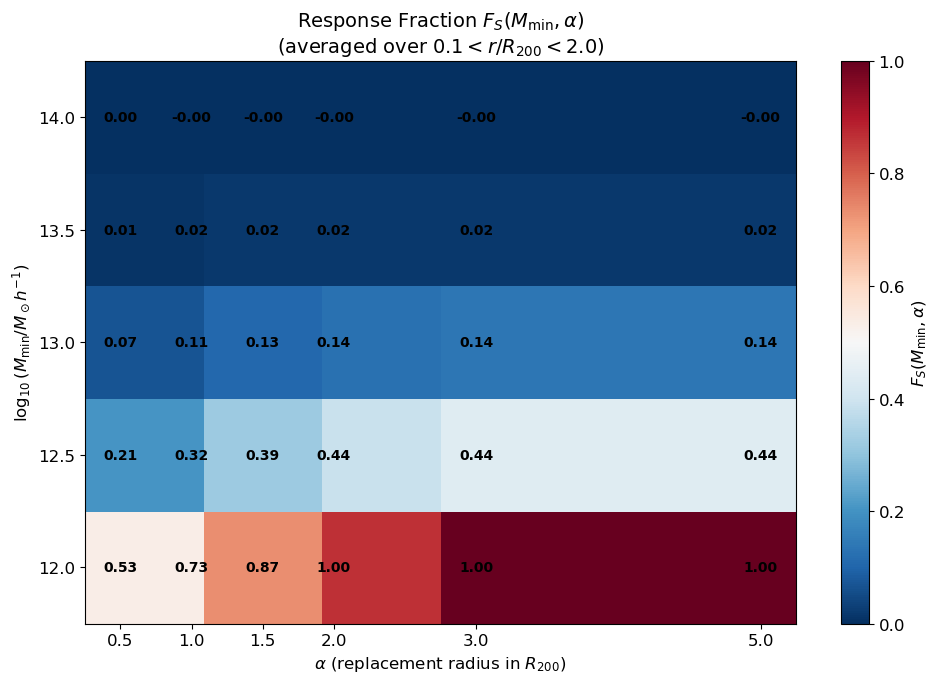

In [34]:
# Average F_S over a radial range (e.g., 0.5-2 R200 where baryonic effects are strongest)
radial_mask = (r_centers >= 0.1) & (r_centers <= 2.0)
F_S_avg = np.mean(F_S_grid[:, :, radial_mask], axis=2)

fig, ax = plt.subplots(figsize=(10, 7))

im = ax.imshow(F_S_avg, origin='lower', aspect='auto', cmap='RdBu_r',
               extent=[alpha_grid[0]-0.25, alpha_grid[-1]+0.25, 
                       M_min_grid[0]-0.25, M_min_grid[-1]+0.25],
               vmin=0, vmax=1)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label='$F_S(M_{\\min}, \\alpha)$')

# Add grid values as text
for i, M_min in enumerate(M_min_grid):
    for j, alpha in enumerate(alpha_grid):
        ax.text(alpha, M_min, f'{F_S_avg[i, j]:.2f}', 
                ha='center', va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('$\\alpha$ (replacement radius in $R_{200}$)', fontsize=12)
ax.set_ylabel('$\\log_{10}(M_{\\min} / M_\odot h^{-1})$', fontsize=12)
ax.set_title('Response Fraction $F_S(M_{\\min}, \\alpha)$\n(averaged over $0.1 < r/R_{200} < 2.0$)', fontsize=14)

ax.set_xticks(alpha_grid)
ax.set_yticks(M_min_grid)

plt.tight_layout()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (6,) and (15,)

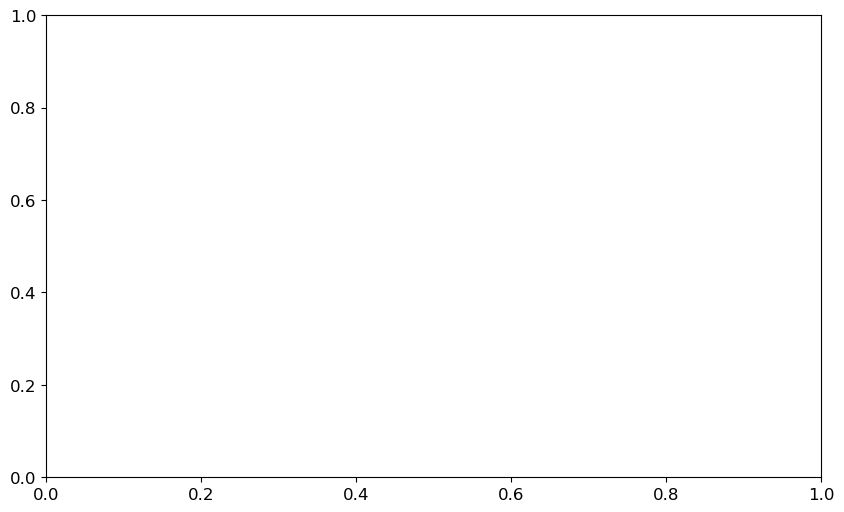

In [35]:
# Plot F_S as a function of alpha for different M_min
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 0.9, len(M_min_grid)))

for i, M_min in enumerate(M_min_grid):
    F_S_at_Mmin = np.mean(F_S_grid[i, :, radial_mask], axis=1)
    ax.plot(alpha_grid, F_S_at_Mmin, 'o-', color=colors[i], lw=2, markersize=8,
            label=f'$M_{{\\min}} = 10^{{{M_min:.1f}}}$ M$_\odot$/h')

ax.axhline(1.0, color='gray', ls='--', alpha=0.5, label='Full Hydro')
ax.axhline(0.0, color='gray', ls=':', alpha=0.5, label='Pure DMO')

ax.set_xlabel('$\\alpha$ (replacement radius in $R_{200}$)', fontsize=12)
ax.set_ylabel('$F_S(M_{\\min}, \\alpha)$', fontsize=12)
ax.set_title('Response Fraction vs. Replacement Radius', fontsize=14)
ax.legend(loc='lower right')
ax.set_xlim(0, 5.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 10. Differential Response Density $\mathcal{R}_S$

From the formalism (Eq. 3):

$$
\mathcal{R}_S(\ln M, \ln\alpha, z)
\equiv
\frac{\partial^3 F_S}{\partial \ln M \, \partial \ln\alpha \, \partial z}
$$

In practice, we compute this via **finite differences**:

$$
\mathcal{R}_S(\ln M_i, \ln\alpha_j)
\approx
\frac{
F_S(M_i, \alpha_j)
- F_S(M_{i+1}, \alpha_j)
- F_S(M_i, \alpha_{j-1})
+ F_S(M_{i+1}, \alpha_{j-1})
}{\Delta\ln M \, \Delta\ln\alpha}
$$

**Physical interpretation:** $\mathcal{R}_S(\ln M, \ln\alpha)$ is a **heatmap/kernel** showing which halo masses and radii contribute to the baryonic change.

In [16]:
def compute_differential_response(F_S_grid, M_min_grid, alpha_grid):
    """
    Compute the differential response density R_S via finite differences.
    
    R_S = d²F_S / (d ln M  d ln α)
    
    Parameters
    ----------
    F_S_grid : array (n_M, n_alpha, ...)
        Response fraction on (M_min, alpha) grid
    M_min_grid : array (n_M,)
        Mass threshold values (log10)
    alpha_grid : array (n_alpha,)
        Radius factor values
    
    Returns
    -------
    R_S : array (n_M-1, n_alpha-1, ...)
        Differential response density
    M_centers : array (n_M-1,)
        Mass bin centers
    alpha_centers : array (n_alpha-1,)
        Alpha bin centers
    """
    n_M = len(M_min_grid)
    n_alpha = len(alpha_grid)
    
    # Compute bin widths in log space
    d_ln_M = np.diff(np.log(10**M_min_grid))  # d(ln M) = ln(10) * d(log10 M)
    d_ln_alpha = np.diff(np.log(alpha_grid))
    
    # Bin centers
    M_centers = (M_min_grid[:-1] + M_min_grid[1:]) / 2
    alpha_centers = np.sqrt(alpha_grid[:-1] * alpha_grid[1:])  # Geometric mean
    
    # Finite difference: mixed second derivative
    # R_S[i,j] = (F[i,j] - F[i+1,j] - F[i,j-1] + F[i+1,j-1]) / (dM * dalpha)
    # But we need to be careful about sign conventions
    
    # Since F_S is cumulative (increases as M_min decreases and alpha increases),
    # we want dF_S/d(-M_min) * dF_S/d(alpha)
    
    extra_dims = F_S_grid.shape[2:]
    R_S = np.zeros((n_M - 1, n_alpha - 1) + extra_dims)
    
    for i in range(n_M - 1):
        for j in range(n_alpha - 1):
            # Mixed partial derivative via finite differences
            # Note: F_S increases with decreasing M_min and increasing alpha
            dF = (F_S_grid[i, j+1] - F_S_grid[i, j] - 
                  F_S_grid[i+1, j+1] + F_S_grid[i+1, j])
            
            R_S[i, j] = dF / (d_ln_M[i] * d_ln_alpha[j])
    
    return R_S, M_centers, alpha_centers

# Compute differential response
R_S, M_centers, alpha_centers = compute_differential_response(F_S_grid, M_min_grid, alpha_grid)

print(f"Differential response R_S computed:")
print(f"  Shape: {R_S.shape}")
print(f"  M centers: {M_centers}")
print(f"  alpha centers: {alpha_centers}")

Differential response R_S computed:
  Shape: (4, 5, 30)
  M centers: [12.25 12.75 13.25 13.75]
  alpha centers: [0.70710678 1.22474487 1.73205081 2.44948974 3.87298335]


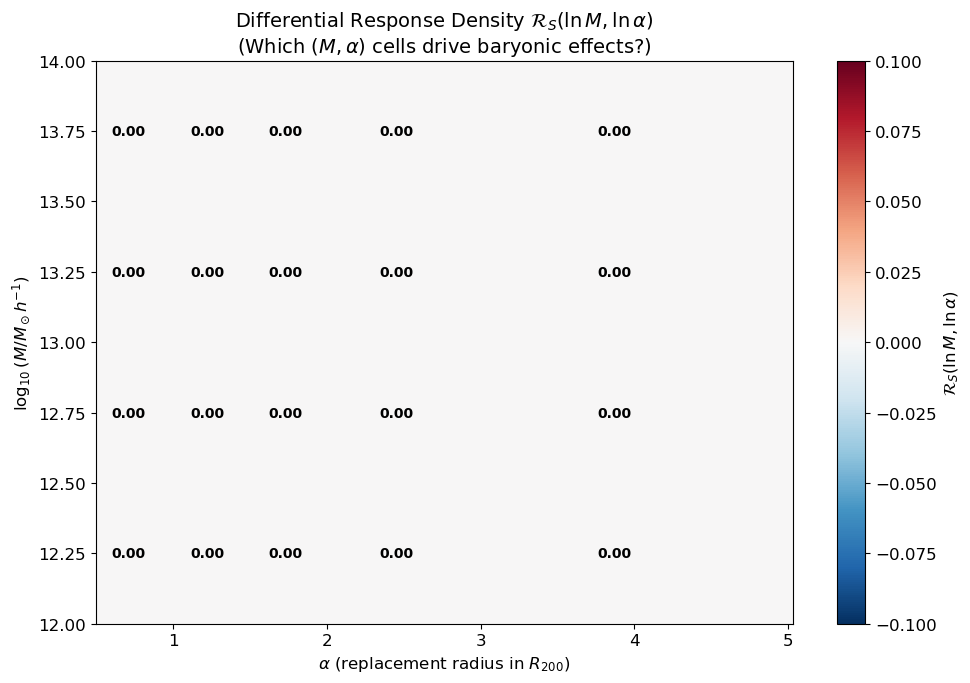

In [17]:
# Visualize the differential response density
R_S_avg = np.mean(R_S[:, :, radial_mask], axis=2)

fig, ax = plt.subplots(figsize=(10, 7))

# Use diverging colormap centered at 0
vmax = np.abs(R_S_avg).max()
im = ax.imshow(R_S_avg, origin='lower', aspect='auto', cmap='RdBu_r',
               extent=[alpha_centers[0]*0.7, alpha_centers[-1]*1.3,
                       M_centers[0]-0.25, M_centers[-1]+0.25],
               vmin=-vmax, vmax=vmax)

cbar = plt.colorbar(im, ax=ax, label='$\\mathcal{R}_S(\\ln M, \\ln\\alpha)$')

# Add values as text
for i, M in enumerate(M_centers):
    for j, alpha in enumerate(alpha_centers):
        ax.text(alpha, M, f'{R_S_avg[i, j]:.2f}', 
                ha='center', va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('$\\alpha$ (replacement radius in $R_{200}$)', fontsize=12)
ax.set_ylabel('$\\log_{10}(M / M_\odot h^{-1})$', fontsize=12)
ax.set_title('Differential Response Density $\\mathcal{R}_S(\\ln M, \\ln\\alpha)$\n'
             '(Which $(M, \\alpha)$ cells drive baryonic effects?)', fontsize=14)

plt.tight_layout()
plt.show()

---
## 11. Interpretation

### Key Questions to Answer:

1. **Which halo masses dominate the baryonic effect?**
   - Integrate $\mathcal{R}_S$ over $\alpha$ to get mass dependence

2. **Which radii matter most?**
   - Integrate $\mathcal{R}_S$ over $M$ to get radius dependence

3. **Is the Miller result reproduced?**
   - If $F_S(M_{\min}=10^{12.5}, \alpha=2) < 1$, even "perfect" halo replacement doesn't capture the full baryonic effect

In [18]:
# Mass dependence: marginalize over alpha
R_S_mass = np.sum(R_S_avg, axis=1) * np.diff(np.log(alpha_grid))  # Sum weighted by d ln alpha

# Radius dependence: marginalize over M
R_S_alpha = np.sum(R_S_avg, axis=0) * np.diff(np.log(10**M_min_grid))  # Sum weighted by d ln M

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mass dependence
ax = axes[0]
ax.bar(M_centers, R_S_mass, width=0.4, color='steelblue', edgecolor='black')
ax.set_xlabel('$\\log_{10}(M / M_\odot h^{-1})$', fontsize=12)
ax.set_ylabel('$\\int \\mathcal{R}_S \\, d\\ln\\alpha$', fontsize=12)
ax.set_title('Baryonic Effect by Halo Mass', fontsize=14)
ax.axhline(0, color='gray', ls='--', alpha=0.5)

# Radius dependence
ax = axes[1]
ax.bar(np.arange(len(alpha_centers)), R_S_alpha, width=0.6, color='coral', edgecolor='black')
ax.set_xticks(np.arange(len(alpha_centers)))
ax.set_xticklabels([f'{a:.1f}' for a in alpha_centers])
ax.set_xlabel('$\\alpha$ (in $R_{200}$)', fontsize=12)
ax.set_ylabel('$\\int \\mathcal{R}_S \\, d\\ln M$', fontsize=12)
ax.set_title('Baryonic Effect by Radius', fontsize=14)
ax.axhline(0, color='gray', ls='--', alpha=0.5)

plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (4,) (5,) 

In [ ]:
# Check the Miller result: F_S at M_min=12.5, alpha=2
# Find closest grid points
i_M = np.argmin(np.abs(M_min_grid - 12.5))
j_alpha = np.argmin(np.abs(alpha_grid - 2.0))

F_S_miller = np.mean(F_S_grid[i_M, j_alpha, radial_mask])

print("="*60)
print("Miller et al. (2025) Test:")
print("="*60)
print(f"Configuration: M_min = 10^{M_min_grid[i_M]:.1f} Msun/h, alpha = {alpha_grid[j_alpha]:.1f}")
print(f"Response fraction F_S = {F_S_miller:.3f}")
print()
if F_S_miller < 1.0:
    missing = (1 - F_S_miller) * 100
    print(f"Result: {missing:.1f}% of the baryonic effect is NOT captured!")
    print("The residual must come from:")
    print("  - Lower mass halos (M < 10^12.5)")
    print("  - Larger radii (r > 2 R200)")
    print("  - Diffuse/non-halo components")
else:
    print("Result: Full baryonic effect captured within this configuration.")

---
## 12. Summary and Next Steps

### What we computed:
1. **Stacked profiles** for DMO and Hydro simulations
2. **Replace profiles** for each $(M_{\min}, \alpha)$ configuration
3. **Response fraction** $F_S(M_{\min}, \alpha)$ showing cumulative baryonic effect
4. **Differential response** $\mathcal{R}_S(\ln M, \ln\alpha)$ showing which cells contribute

### Next steps for full formalism:
1. **Apply to 2D/3D power spectra** instead of profiles
2. **Include redshift dependence** using multiple snapshots
3. **Compare across observables**: $P(k)$, $C_\ell$, peak counts
4. **Test BCMs**: compute $\mathcal{R}_S^{\rm BCM}$ and compare to $\mathcal{R}_S^{\rm Hydro}$

In [ ]:
print("Notebook complete!")
print("\nTo extend this analysis:")
print("1. Load Replace lensplanes and compute C_ell")
print("2. Compute peak counts from convergence maps")
print("3. Run BCM and compare response patterns")

---
---
# Part 2: Power Spectrum Analysis with 2D Maps

Now we extend the formalism to **2D projected power spectra** $P_{2D}(k)$ using the density maps generated by `generate_all_unified.py`.

This is closer to weak lensing observables since:
- Convergence $\kappa \propto$ projected mass
- $C_\ell \propto P_{2D}(k)$ via Limber approximation

We'll use **Pylians3** for power spectrum computation.

In [ ]:
import Pk_library as PKL  # Pylians3 power spectrum module

## 13. Load 2D Projected Density Maps

Load the DMO, Hydro, and Replace maps from the snapshot directory.

**Map structure:**
- `dmo.npz`: Full DMO density field
- `hydro.npz`: Full Hydro density field  
- `replace_M{mass_min}.npz`: Replace field for given mass threshold

In [ ]:
# ============================================================================
# MAP CONFIGURATION
# ============================================================================

# Directory containing projected maps
SNAP_DIR = os.path.join(OUTPUT_DIR, f'snap{SNAP:03d}', 'projected')

# Grid resolution (should match what was used in generate_all_unified.py)
GRID_RES = 4096  # or 1024, 2048 depending on your run

# Mass thresholds for Replace maps (log10 Msun/h)
# These should match what you generated
REPLACE_MASS_THRESHOLDS = [12.0, 12.5, 13.0, 13.5, 14.0]

# R factors for Replace maps (in units of R200)
# If you have multiple R factors, list them here
REPLACE_R_FACTORS = [0.5, 1.0, 2.0, 3.0, 5.0]

print(f"Map directory: {SNAP_DIR}")
print(f"Grid resolution: {GRID_RES}")
print(f"Mass thresholds: {REPLACE_MASS_THRESHOLDS}")
print(f"R factors: {REPLACE_R_FACTORS}")

In [ ]:
def load_density_map(filepath):
    """
    Load a 2D density map from npz file.
    
    Parameters
    ----------
    filepath : str
        Path to the .npz file
    
    Returns
    -------
    field : array (grid_res, grid_res)
        2D density field
    metadata : dict
        Box size, grid resolution, etc.
    """
    data = np.load(filepath)
    field = data['field']
    metadata = {
        'box_size': float(data['box_size']),
        'grid_resolution': int(data['grid_resolution']),
        'snapshot': int(data['snapshot']),
    }
    return field, metadata


# Load DMO and Hydro maps
print("Loading DMO map...")
dmo_map, dmo_meta = load_density_map(os.path.join(SNAP_DIR, 'dmo.npz'))
print(f"  Shape: {dmo_map.shape}, Box: {dmo_meta['box_size']} Mpc/h")

print("Loading Hydro map...")
hydro_map, hydro_meta = load_density_map(os.path.join(SNAP_DIR, 'hydro.npz'))
print(f"  Shape: {hydro_map.shape}, Box: {hydro_meta['box_size']} Mpc/h")

# Load Replace maps for different mass thresholds
replace_maps = {}
for M_min in REPLACE_MASS_THRESHOLDS:
    mass_label = f"M{M_min:.1f}".replace('.', 'p')
    filepath = os.path.join(SNAP_DIR, f'replace_{mass_label}.npz')
    if os.path.exists(filepath):
        replace_maps[M_min], _ = load_density_map(filepath)
        print(f"Loaded Replace map for M_min = 10^{M_min}")
    else:
        print(f"  Warning: {filepath} not found")

print(f"\nLoaded {len(replace_maps)} Replace maps")

## 14. Compute 2D Power Spectra with Pylians3

Convert density maps to overdensity fields $\delta = \rho/\bar{\rho} - 1$ and compute power spectra.

**Pylians3 `Pk_plane`** computes:
$$
P_{2D}(k) = \langle |\tilde{\delta}(\mathbf{k})|^2 \rangle
$$

where the average is over annuli in $k$-space.

In [ ]:
def compute_2d_power_spectrum(density_field, box_size, threads=4):
    """
    Compute 2D power spectrum from a density field using Pylians3.
    
    Parameters
    ----------
    density_field : array (N, N)
        2D density field (mass or counts)
    box_size : float
        Box size in Mpc/h
    threads : int
        Number of threads for FFT
    
    Returns
    -------
    k : array
        Wavenumber bins [h/Mpc]
    Pk : array
        Power spectrum P(k) [(Mpc/h)^2]
    """
    # Convert to overdensity field: delta = rho / rho_mean - 1
    mean_density = np.mean(density_field)
    if mean_density > 0:
        delta = (density_field / mean_density - 1.0).astype(np.float32)
    else:
        delta = np.zeros_like(density_field, dtype=np.float32)
    
    # Ensure C-contiguous array
    delta = np.ascontiguousarray(delta)
    
    # Compute 2D power spectrum with Pylians3
    Pk2D = PKL.Pk_plane(delta, box_size, 'None', threads)
    
    k = Pk2D.k      # Wavenumber [h/Mpc]
    Pk = Pk2D.Pk    # Power spectrum [(Mpc/h)^2]
    
    return k, Pk


# Compute power spectra for DMO and Hydro
print("Computing DMO power spectrum...")
k_dmo, Pk_dmo = compute_2d_power_spectrum(dmo_map, BOX_SIZE)
print(f"  k range: {k_dmo[0]:.4f} - {k_dmo[-1]:.2f} h/Mpc")

print("Computing Hydro power spectrum...")
k_hydro, Pk_hydro = compute_2d_power_spectrum(hydro_map, BOX_SIZE)

# Compute power spectra for Replace maps
Pk_replace = {}
for M_min, replace_map in replace_maps.items():
    print(f"Computing Replace power spectrum for M_min = 10^{M_min}...")
    k_rep, Pk_rep = compute_2d_power_spectrum(replace_map, BOX_SIZE)
    Pk_replace[M_min] = Pk_rep

print(f"\nComputed {2 + len(Pk_replace)} power spectra")

## 15. Visualize Power Spectra: DMO vs Hydro vs Replace

Compare the power spectra to see:
1. **Baryonic suppression**: $P_{\rm Hydro}(k) / P_{\rm DMO}(k) < 1$ at high $k$
2. **Replace interpolation**: How close does Replace get to Hydro?

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Absolute power spectra
ax = axes[0]
ax.loglog(k_dmo, Pk_dmo, 'b-', lw=2, label='DMO')
ax.loglog(k_hydro, Pk_hydro, 'r-', lw=2, label='Hydro')

colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(Pk_replace)))
for i, (M_min, Pk) in enumerate(sorted(Pk_replace.items())):
    ax.loglog(k_dmo, Pk, '--', color=colors[i], lw=1.5, 
              label=f'Replace $M_{{\\min}}=10^{{{M_min:.1f}}}$')

ax.set_xlabel('$k$ [h/Mpc]', fontsize=12)
ax.set_ylabel('$P_{2D}(k)$ [(Mpc/h)$^2$]', fontsize=12)
ax.set_title('2D Power Spectra', fontsize=14)
ax.legend(fontsize=9, loc='lower left')
ax.set_xlim(k_dmo[1], k_dmo[-1])
ax.grid(True, alpha=0.3)

# Right: Ratio to DMO
ax = axes[1]
ax.semilogx(k_dmo, Pk_hydro / Pk_dmo, 'r-', lw=2, label='Hydro / DMO')

for i, (M_min, Pk) in enumerate(sorted(Pk_replace.items())):
    ax.semilogx(k_dmo, Pk / Pk_dmo, '--', color=colors[i], lw=1.5,
                label=f'Replace $M_{{\\min}}=10^{{{M_min:.1f}}}$ / DMO')

ax.axhline(1.0, color='gray', ls=':', alpha=0.5)
ax.set_xlabel('$k$ [h/Mpc]', fontsize=12)
ax.set_ylabel('$P(k) / P_{\\rm DMO}(k)$', fontsize=12)
ax.set_title('Power Spectrum Ratio (Baryonic Suppression)', fontsize=14)
ax.legend(fontsize=9, loc='lower left')
ax.set_xlim(k_dmo[1], k_dmo[-1])
ax.set_ylim(0.7, 1.1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 16. Response Fraction $F_{P(k)}(M_{\min}, \alpha)$ for Power Spectrum

Apply the response formalism to the power spectrum observable:

$$
F_{P(k)}(M_{\min}, \alpha) = \frac{P_{\rm R}(k; M_{\min}, \alpha) - P_{\rm D}(k)}{P_{\rm H}(k) - P_{\rm D}(k)}
$$

This tells us what fraction of the baryonic suppression at each $k$ is captured by replacing halos above $M_{\min}$.

In [ ]:
# Compute response fraction for power spectrum at each k
F_Pk = {}
for M_min, Pk in Pk_replace.items():
    F_Pk[M_min] = compute_response_fraction(Pk, Pk_dmo, Pk_hydro)

# Plot F_Pk as a function of k for different M_min
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 0.9, len(F_Pk)))
for i, (M_min, F) in enumerate(sorted(F_Pk.items())):
    ax.semilogx(k_dmo, F, '-', color=colors[i], lw=2,
                label=f'$M_{{\\min}} = 10^{{{M_min:.1f}}}$ M$_\\odot$/h')

ax.axhline(1.0, color='gray', ls='--', alpha=0.5, label='Full Hydro')
ax.axhline(0.0, color='gray', ls=':', alpha=0.5, label='Pure DMO')

ax.set_xlabel('$k$ [h/Mpc]', fontsize=12)
ax.set_ylabel('$F_{P(k)}(M_{\\min})$', fontsize=12)
ax.set_title('Power Spectrum Response Fraction vs. Wavenumber', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.set_xlim(k_dmo[1], k_dmo[-1])
ax.set_ylim(-0.2, 1.2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 17. Scale-Dependent Response Analysis

The response fraction varies with scale $k$:
- **Large scales (low $k$)**: Little baryonic effect → $F_{P(k)} \approx 0$ (or undefined)
- **Small scales (high $k$)**: Strong baryonic suppression → $F_{P(k)}$ reveals mass contribution

Let's analyze the response at specific scales relevant for weak lensing.

In [ ]:
# Define k bins for analysis (typical weak lensing scales)
k_analysis = [0.5, 1.0, 2.0, 5.0, 10.0]  # h/Mpc

# Find closest k indices
def find_nearest_k_idx(k_array, k_target):
    return np.argmin(np.abs(k_array - k_target))

k_indices = {k_val: find_nearest_k_idx(k_dmo, k_val) for k_val in k_analysis}

# Build response matrix: F_Pk[M_min, k]
M_min_values = sorted(F_Pk.keys())
F_Pk_matrix = np.zeros((len(M_min_values), len(k_analysis)))

for i, M_min in enumerate(M_min_values):
    for j, k_val in enumerate(k_analysis):
        idx = k_indices[k_val]
        F_Pk_matrix[i, j] = F_Pk[M_min][idx]

# Display as table
print("Response Fraction F_P(k) by Mass Threshold and Scale")
print("=" * 70)
header = f"{'M_min':>12} |" + "".join([f"  k={k:.1f}  |" for k in k_analysis])
print(header)
print("-" * 70)
for i, M_min in enumerate(M_min_values):
    row = f"10^{M_min:.1f}     |"
    for j in range(len(k_analysis)):
        row += f"  {F_Pk_matrix[i, j]:6.3f}  |"
    print(row)
print("=" * 70)

In [ ]:
# Heatmap of F_Pk(M_min, k)
fig, ax = plt.subplots(figsize=(10, 6))

im = ax.imshow(F_Pk_matrix, origin='lower', aspect='auto', cmap='RdBu_r',
               vmin=0, vmax=1)

# Labels
ax.set_xticks(np.arange(len(k_analysis)))
ax.set_xticklabels([f'{k:.1f}' for k in k_analysis])
ax.set_yticks(np.arange(len(M_min_values)))
ax.set_yticklabels([f'$10^{{{M:.1f}}}$' for M in M_min_values])

ax.set_xlabel('$k$ [h/Mpc]', fontsize=12)
ax.set_ylabel('$M_{\\min}$ [M$_\\odot$/h]', fontsize=12)
ax.set_title('Power Spectrum Response $F_{P(k)}(M_{\\min})$\n'
             '(What fraction of baryonic suppression is captured?)', fontsize=14)

# Add text annotations
for i in range(len(M_min_values)):
    for j in range(len(k_analysis)):
        text = ax.text(j, i, f'{F_Pk_matrix[i, j]:.2f}',
                       ha='center', va='center', fontsize=11, fontweight='bold',
                       color='white' if 0.3 < F_Pk_matrix[i, j] < 0.7 else 'black')

cbar = plt.colorbar(im, ax=ax, label='$F_{P(k)}$')

plt.tight_layout()
plt.show()

## 18. Differential Response for Power Spectrum

Compute the differential response density for the power spectrum:

$$
\mathcal{R}_{P(k)}(\ln M) = \frac{dF_{P(k)}}{d\ln M}
$$

This tells us which mass bins contribute most to the baryonic suppression at each scale.

In [ ]:
# Compute differential response dF/d(ln M) for power spectrum
# Using finite differences on F_Pk_matrix

d_ln_M = np.diff(np.log(10**np.array(M_min_values)))  # d(ln M)
M_bin_centers = [(M_min_values[i] + M_min_values[i+1]) / 2 for i in range(len(M_min_values)-1)]

# dF/d(ln M) for each k
dF_dlnM = np.zeros((len(M_min_values) - 1, len(k_analysis)))
for j in range(len(k_analysis)):
    # Note: F increases as M_min decreases, so we use -dF/d(ln M_min)
    dF_dlnM[:, j] = -np.diff(F_Pk_matrix[:, j]) / d_ln_M

# Plot differential response by mass for different k
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: dF/dlnM as function of mass for each k
ax = axes[0]
colors = plt.cm.plasma(np.linspace(0.2, 0.9, len(k_analysis)))
for j, k_val in enumerate(k_analysis):
    ax.plot(M_bin_centers, dF_dlnM[:, j], 'o-', color=colors[j], lw=2, markersize=8,
            label=f'$k = {k_val:.1f}$ h/Mpc')

ax.axhline(0, color='gray', ls='--', alpha=0.5)
ax.set_xlabel('$\\log_{10}(M / M_\\odot h^{-1})$', fontsize=12)
ax.set_ylabel('$dF_{P(k)} / d\\ln M$', fontsize=12)
ax.set_title('Differential Response: Which masses matter?', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Right: Bar chart for k=1 h/Mpc
ax = axes[1]
k_idx = k_analysis.index(1.0) if 1.0 in k_analysis else 1
ax.bar(np.arange(len(M_bin_centers)), dF_dlnM[:, k_idx], 
       color='steelblue', edgecolor='black', alpha=0.8)
ax.set_xticks(np.arange(len(M_bin_centers)))
ax.set_xticklabels([f'$10^{{{M:.1f}}}$' for M in M_bin_centers])
ax.set_xlabel('Halo Mass Bin Center [M$_\\odot$/h]', fontsize=12)
ax.set_ylabel('$dF_{P(k)} / d\\ln M$', fontsize=12)
ax.set_title(f'Mass Contribution to $P(k)$ Suppression at $k={k_analysis[k_idx]:.1f}$ h/Mpc', fontsize=14)
ax.axhline(0, color='gray', ls='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 19. Quantify Missing Baryonic Effect (Miller Test for P(k))

Test the key result: Does replacing halos above $M_{\min} = 10^{12.5}$ M$_\odot$/h capture all the baryonic suppression?

If $F_{P(k)} < 1$ at high $k$, there's a **missing** component from:
- Lower mass halos ($M < 10^{12.5}$)
- Larger radii ($r > \alpha R_{200}$)
- Diffuse/non-halo baryons

In [ ]:
# Miller test: What fraction of suppression is captured at M_min=12.5?
M_min_test = 12.5

if M_min_test in F_Pk:
    F_test = F_Pk[M_min_test]
    
    print("=" * 70)
    print(f"MILLER TEST: Response at M_min = 10^{M_min_test} M_sun/h")
    print("=" * 70)
    print()
    
    # Compute suppression at different scales
    print(f"{'k [h/Mpc]':>12} | {'P_H/P_D':>10} | {'F_P(k)':>10} | {'Missing':>10}")
    print("-" * 50)
    
    for k_val in k_analysis:
        idx = find_nearest_k_idx(k_dmo, k_val)
        suppression = Pk_hydro[idx] / Pk_dmo[idx]
        F_val = F_test[idx]
        missing = (1 - F_val) * 100 if F_val < 1 else 0
        
        print(f"{k_val:>12.1f} | {suppression:>10.4f} | {F_val:>10.3f} | {missing:>9.1f}%")
    
    print("-" * 50)
    print()
    
    # Summary statistics
    # Average F over k > 1 h/Mpc (where baryonic effects are strongest)
    high_k_mask = k_dmo > 1.0
    F_avg_high_k = np.mean(F_test[high_k_mask])
    
    print(f"Average F_P(k) for k > 1 h/Mpc: {F_avg_high_k:.3f}")
    print(f"Missing effect: {(1 - F_avg_high_k) * 100:.1f}%")
    print()
    
    if F_avg_high_k < 0.9:
        print("CONCLUSION: Significant baryonic effect NOT captured by")
        print(f"            halos above 10^{M_min_test} M_sun/h!")
        print("            Need lower masses, larger radii, or diffuse component.")
    else:
        print("CONCLUSION: Most baryonic effect captured by")
        print(f"            halos above 10^{M_min_test} M_sun/h.")
else:
    print(f"No Replace map for M_min = 10^{M_min_test} available")

## 20. Compare Profile-Based vs Power Spectrum Response

A key test of the formalism: Do different observables show the **same** mass dependence?

Compare $F_S(M_{\min})$ from:
1. **Profiles** (Section 8-9)
2. **2D Power Spectrum** (Section 16-17)

If they differ significantly, baryonic effects have **different origins** for different statistics.

In [ ]:
# Compare response fractions from profiles vs power spectrum

fig, ax = plt.subplots(figsize=(10, 6))

# Profile-based F_S (from Section 8, averaged over radial bins)
# Use the F_S_grid computed earlier with alpha = max (full replacement)
if 'F_S_grid' in dir() and len(F_S_grid) > 0:
    # Find alpha = 5.0 (or max available)
    j_alpha_max = len(alpha_grid) - 1
    F_profile = np.mean(F_S_grid[:, j_alpha_max, radial_mask], axis=1)
    
    ax.plot(M_min_grid, F_profile, 'o-', color='steelblue', lw=2, markersize=10,
            label=f'Profiles ($\\alpha = {alpha_grid[j_alpha_max]:.1f}$, avg over $r$)')

# Power spectrum F_S at k=1 h/Mpc
k_target = 1.0
k_idx = find_nearest_k_idx(k_dmo, k_target)
F_Pk_at_k1 = [F_Pk[M][k_idx] for M in sorted(F_Pk.keys())]
ax.plot(sorted(F_Pk.keys()), F_Pk_at_k1, 's-', color='coral', lw=2, markersize=10,
        label=f'$P(k)$ at $k = {k_target:.1f}$ h/Mpc')

# Power spectrum at k=5 h/Mpc
k_target_high = 5.0
k_idx_high = find_nearest_k_idx(k_dmo, k_target_high)
F_Pk_at_k5 = [F_Pk[M][k_idx_high] for M in sorted(F_Pk.keys())]
ax.plot(sorted(F_Pk.keys()), F_Pk_at_k5, '^-', color='green', lw=2, markersize=10,
        label=f'$P(k)$ at $k = {k_target_high:.1f}$ h/Mpc')

ax.axhline(1.0, color='gray', ls='--', alpha=0.5)
ax.axhline(0.0, color='gray', ls=':', alpha=0.5)

ax.set_xlabel('$\\log_{10}(M_{\\min} / M_\\odot h^{-1})$', fontsize=12)
ax.set_ylabel('Response Fraction $F_S(M_{\\min})$', fontsize=12)
ax.set_title('Comparison: Profile vs Power Spectrum Response', fontsize=14)
ax.legend(loc='lower right', fontsize=11)
ax.set_ylim(-0.1, 1.2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quantify the difference
print("\nConsistency check across observables:")
print("=" * 50)
if 'F_profile' in dir():
    for i, M_min in enumerate(sorted(F_Pk.keys())):
        if M_min in M_min_grid:
            j = list(M_min_grid).index(M_min)
            diff = abs(F_profile[j] - F_Pk_at_k1[i])
            print(f"M_min = 10^{M_min:.1f}: |F_profile - F_P(k=1)| = {diff:.3f}")

## 21. Summary: Power Spectrum Analysis

### Key Results:

1. **Baryonic Suppression**: $P_{\rm Hydro}(k) / P_{\rm DMO}(k)$ shows suppression at $k \gtrsim 1$ h/Mpc

2. **Response Fraction $F_{P(k)}(M_{\min})$**: 
   - Quantifies what fraction of suppression comes from halos above $M_{\min}$
   - Scale-dependent: different $k$ probe different mass ranges

3. **Differential Response $dF/d\ln M$**:
   - Shows which mass bins dominate the baryonic effect
   - Can vary with scale $k$

4. **Cross-Observable Comparison**:
   - Profiles vs Power Spectrum may show different mass sensitivities
   - This reveals whether BCM calibrated to one statistic transfers to others

### Next Steps:
- Add multiple $\alpha$ (radius) values by loading Replace maps with different R factors
- Include redshift evolution using multiple snapshots
- Apply to BCM outputs for consistency test

In [ ]:
# Final summary plot
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Power spectrum ratio
ax = axes[0, 0]
ax.semilogx(k_dmo, Pk_hydro / Pk_dmo, 'r-', lw=2, label='Hydro / DMO')
ax.axhline(1.0, color='gray', ls='--', alpha=0.5)
ax.set_xlabel('$k$ [h/Mpc]')
ax.set_ylabel('$P(k) / P_{\\rm DMO}(k)$')
ax.set_title('(a) Baryonic Suppression')
ax.set_xlim(k_dmo[1], k_dmo[-1])
ax.set_ylim(0.7, 1.05)
ax.grid(True, alpha=0.3)
ax.legend()

# 2. Response fraction vs k
ax = axes[0, 1]
for i, (M_min, F) in enumerate(sorted(F_Pk.items())):
    ax.semilogx(k_dmo, F, '-', lw=2, label=f'$M_{{\\min}}=10^{{{M_min:.1f}}}$')
ax.axhline(1.0, color='gray', ls='--', alpha=0.5)
ax.set_xlabel('$k$ [h/Mpc]')
ax.set_ylabel('$F_{P(k)}$')
ax.set_title('(b) Response Fraction vs Scale')
ax.set_xlim(k_dmo[1], k_dmo[-1])
ax.set_ylim(-0.1, 1.2)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# 3. Response heatmap
ax = axes[1, 0]
im = ax.imshow(F_Pk_matrix, origin='lower', aspect='auto', cmap='RdBu_r', vmin=0, vmax=1)
ax.set_xticks(np.arange(len(k_analysis)))
ax.set_xticklabels([f'{k:.1f}' for k in k_analysis])
ax.set_yticks(np.arange(len(M_min_values)))
ax.set_yticklabels([f'$10^{{{M:.1f}}}$' for M in M_min_values])
ax.set_xlabel('$k$ [h/Mpc]')
ax.set_ylabel('$M_{\\min}$')
ax.set_title('(c) Response Fraction $F_{P(k)}(M_{\\min})$')
for i in range(len(M_min_values)):
    for j in range(len(k_analysis)):
        ax.text(j, i, f'{F_Pk_matrix[i, j]:.2f}', ha='center', va='center', fontsize=10)
plt.colorbar(im, ax=ax)

# 4. Differential response at k=1 h/Mpc
ax = axes[1, 1]
k_plot_idx = k_analysis.index(1.0) if 1.0 in k_analysis else 1
ax.bar(np.arange(len(M_bin_centers)), dF_dlnM[:, k_plot_idx], 
       color='steelblue', edgecolor='black')
ax.set_xticks(np.arange(len(M_bin_centers)))
ax.set_xticklabels([f'$10^{{{M:.1f}}}$' for M in M_bin_centers])
ax.set_xlabel('Mass Bin')
ax.set_ylabel('$dF_{P(k)}/d\\ln M$')
ax.set_title(f'(d) Differential Response at $k={k_analysis[k_plot_idx]:.1f}$ h/Mpc')
ax.axhline(0, color='gray', ls='--', alpha=0.5)

plt.tight_layout()
plt.savefig('formalism_power_spectrum_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSummary figure saved to: formalism_power_spectrum_summary.png")

---
---
# Part 3: Weak Lensing Convergence via Born Approximation

Now we extend to **weak lensing convergence** $\kappa$ by ray-tracing through lensplanes using the **Born approximation**.

The convergence is:
$$
\kappa(\boldsymbol{\theta}) = \frac{3H_0^2 \Omega_m}{2c^2} \int_0^{\chi_s} d\chi \, \frac{\chi(\chi_s - \chi)}{\chi_s} \frac{\delta(\chi\boldsymbol{\theta}, \chi)}{a(\chi)}
$$

For discrete lensplanes, this becomes:
$$
\kappa(\boldsymbol{\theta}) = \sum_i W_i \, \Sigma_i(\boldsymbol{\theta})
$$

where $W_i$ is the lensing weight and $\Sigma_i$ is the surface mass density of plane $i$.

## 22. Cosmological Setup for Lensing

Define cosmological parameters and functions needed for the Born approximation.

In [ ]:
# ============================================================================
# COSMOLOGICAL PARAMETERS (IllustrisTNG / Planck 2015)
# ============================================================================

# Cosmology
H0 = 67.74  # km/s/Mpc
h = H0 / 100.0
Omega_m = 0.3089
Omega_L = 1 - Omega_m
c_light = 299792.458  # km/s

# Derived constants
H0_over_c = H0 / c_light  # 1/Mpc (in units where h=1, this is h/Mpc)

# Critical surface density prefactor: 3 H0^2 Omega_m / (2 c^2)
# In units of h^2 Msun / Mpc^2 per (Mpc/h)
KAPPA_PREFACTOR = 3 * (H0_over_c)**2 * Omega_m / 2  # h^2/Mpc^2

print("Cosmological Parameters:")
print(f"  H0 = {H0} km/s/Mpc")
print(f"  Omega_m = {Omega_m}")
print(f"  Omega_L = {Omega_L}")
print(f"  Kappa prefactor = {KAPPA_PREFACTOR:.6e} h^2/Mpc^2")

In [ ]:
def E(z):
    """Hubble parameter E(z) = H(z)/H0."""
    return np.sqrt(Omega_m * (1 + z)**3 + Omega_L)

def comoving_distance(z, n_steps=1000):
    """
    Compute comoving distance chi(z) in Mpc/h.
    
    chi(z) = (c/H0) * integral_0^z dz' / E(z')
    """
    if np.isscalar(z):
        z_arr = np.array([z])
    else:
        z_arr = np.asarray(z)
    
    chi = np.zeros_like(z_arr, dtype=float)
    
    for i, z_val in enumerate(z_arr):
        if z_val <= 0:
            chi[i] = 0
        else:
            z_int = np.linspace(0, z_val, n_steps)
            integrand = 1.0 / E(z_int)
            chi[i] = np.trapz(integrand, z_int) * (c_light / H0)  # Mpc/h
    
    return chi[0] if np.isscalar(z) else chi

def scale_factor(z):
    """Scale factor a = 1/(1+z)."""
    return 1.0 / (1.0 + z)

# Test: comoving distance to z=1
chi_z1 = comoving_distance(1.0)
print(f"Comoving distance to z=1: {chi_z1:.2f} Mpc/h")

## 23. Lensplane Configuration

Define the lensplane structure: snapshots, redshifts, and file paths.

In [ ]:
# ============================================================================
# LENSPLANE CONFIGURATION
# ============================================================================

# Lensplane directory
LP_BASE = '/mnt/home/mlee1/ceph/hydro_replace_LP'
LP_DIR = os.path.join(LP_BASE, SIM_LABEL)

# Snapshot order and redshifts (from generate_all_unified.py)
# These are the 20 snapshots used for ray-tracing from z~0 to z~2
SNAPSHOT_ORDER = [96, 90, 85, 80, 76, 71, 67, 63, 59, 56, 52, 49, 46, 43, 41, 38, 35, 33, 31, 29]

# Approximate redshifts for each snapshot (IllustrisTNG)
# You may need to adjust these based on your simulation
SNAPSHOT_REDSHIFTS = {
    96: 0.02, 90: 0.10, 85: 0.20, 80: 0.30, 76: 0.40,
    71: 0.52, 67: 0.64, 63: 0.79, 59: 0.95, 56: 1.10,
    52: 1.30, 49: 1.50, 46: 1.74, 43: 2.00, 41: 2.21,
    38: 2.44, 35: 2.73, 33: 3.01, 31: 3.28, 29: 3.57
}

# Planes per snapshot (pps) - depth slicing
PPS = 2  # Each snapshot is divided into 2 slices

# Lensplane grid resolution
LP_GRID = 4096

# Number of realizations (LP directories)
N_REALIZATIONS = 10

# Source redshift for lensing (single source plane for simplicity)
Z_SOURCE = 1.0

print(f"Lensplane directory: {LP_DIR}")
print(f"Snapshots: {len(SNAPSHOT_ORDER)} from snap {SNAPSHOT_ORDER[0]} (z={SNAPSHOT_REDSHIFTS[96]:.2f}) to snap {SNAPSHOT_ORDER[-1]} (z={SNAPSHOT_REDSHIFTS[29]:.2f})")
print(f"Planes per snapshot: {PPS}")
print(f"Total planes: {len(SNAPSHOT_ORDER) * PPS}")
print(f"Source redshift: z_s = {Z_SOURCE}")

## 24. Compute Lensing Weights

For each lensplane, compute the lensing weight (efficiency) for sources at $z_s$:

$$
W_i = \frac{3 H_0^2 \Omega_m}{2 c^2} \frac{\chi_i (\chi_s - \chi_i)}{\chi_s} \frac{\Delta\chi_i}{a_i}
$$

where:
- $\chi_i$ = comoving distance to plane $i$
- $\chi_s$ = comoving distance to source
- $\Delta\chi_i$ = thickness of plane $i$
- $a_i$ = scale factor at plane $i$

In [ ]:
def compute_lensing_weights(snapshot_order, snapshot_redshifts, z_source, pps, box_size):
    """
    Compute lensing weights for Born approximation.
    
    Parameters
    ----------
    snapshot_order : list
        Ordered list of snapshot numbers
    snapshot_redshifts : dict
        Snapshot number -> redshift mapping
    z_source : float
        Source redshift
    pps : int
        Planes per snapshot
    box_size : float
        Box size in Mpc/h (plane thickness = box_size / pps)
    
    Returns
    -------
    weights : array (n_planes,)
        Lensing weight for each plane
    plane_info : list of dict
        Info about each plane (snap, z, chi, etc.)
    """
    chi_source = comoving_distance(z_source)
    plane_thickness = box_size / pps  # Mpc/h
    
    weights = []
    plane_info = []
    
    for snap_idx, snap in enumerate(snapshot_order):
        z_snap = snapshot_redshifts[snap]
        
        # Skip planes beyond source
        if z_snap >= z_source:
            continue
        
        # Each snapshot has 'pps' slices
        for pps_idx in range(pps):
            # Effective redshift for this slice (midpoint)
            # Approximate: all slices at same z for simplicity
            z_plane = z_snap
            chi_plane = comoving_distance(z_plane)
            a_plane = scale_factor(z_plane)
            
            # Lensing efficiency: chi * (chi_s - chi) / chi_s
            if chi_plane < chi_source:
                efficiency = chi_plane * (chi_source - chi_plane) / chi_source
            else:
                efficiency = 0
            
            # Full weight including prefactor and plane thickness
            # W = (3 H0^2 Omega_m / 2 c^2) * efficiency / a * delta_chi
            weight = KAPPA_PREFACTOR * efficiency / a_plane * plane_thickness
            
            weights.append(weight)
            plane_info.append({
                'snap': snap,
                'snap_idx': snap_idx,
                'pps_idx': pps_idx,
                'plane_idx': snap_idx * pps + pps_idx,
                'z': z_plane,
                'chi': chi_plane,
                'a': a_plane,
                'weight': weight
            })
    
    return np.array(weights), plane_info

# Compute weights
lensing_weights, plane_info = compute_lensing_weights(
    SNAPSHOT_ORDER, SNAPSHOT_REDSHIFTS, Z_SOURCE, PPS, BOX_SIZE
)

print(f"Number of planes (z < z_s={Z_SOURCE}): {len(lensing_weights)}")
print(f"\nLensing weights for first few planes:")
print(f"{'Plane':>6} | {'Snap':>6} | {'z':>6} | {'chi':>10} | {'Weight':>12}")
print("-" * 55)
for i, info in enumerate(plane_info[:10]):
    print(f"{info['plane_idx']:>6} | {info['snap']:>6} | {info['z']:>6.3f} | {info['chi']:>10.2f} | {info['weight']:>12.6e}")
print(f"...")
print(f"\nTotal weight sum: {np.sum(lensing_weights):.6f}")

## 25. Load Lensplanes

Load the lensplane binary files. Format: `[int32: grid_size] [float64: data] [int32: grid_size]`

In [ ]:
def read_lensplane(filepath):
    """
    Read lensplane from binary file (lux format).
    
    Format: [int32: grid_size] [float64[grid²]: data] [int32: grid_size]
    
    Parameters
    ----------
    filepath : str
        Path to lensplane file
    
    Returns
    -------
    delta : array (grid, grid)
        Surface mass density (or overdensity) field
    grid_size : int
        Grid resolution
    """
    with open(filepath, 'rb') as f:
        # Read header
        grid_size = np.frombuffer(f.read(4), dtype=np.int32)[0]
        
        # Read data
        n_pixels = grid_size * grid_size
        delta = np.frombuffer(f.read(n_pixels * 8), dtype=np.float64)
        delta = delta.reshape((grid_size, grid_size))
        
        # Read footer (for verification)
        grid_check = np.frombuffer(f.read(4), dtype=np.int32)[0]
        
        if grid_check != grid_size:
            print(f"Warning: grid size mismatch in {filepath}")
    
    return delta, grid_size


def load_lensplanes_for_model(model_name, lp_dir, realization=0, plane_info=None):
    """
    Load all lensplanes for a given model.
    
    Parameters
    ----------
    model_name : str
        'dmo', 'hydro', or 'hydro_replace_Ml_..._R_...'
    lp_dir : str
        Base lensplane directory
    realization : int
        Which LP realization (0-9)
    plane_info : list
        Plane info from compute_lensing_weights (to know which planes to load)
    
    Returns
    -------
    planes : list of arrays
        List of 2D lensplane arrays
    """
    lp_subdir = os.path.join(lp_dir, model_name, f'LP_{realization:02d}')
    
    planes = []
    for info in plane_info:
        plane_idx = info['plane_idx']
        filepath = os.path.join(lp_subdir, f'lenspot{plane_idx:02d}.dat')
        
        if os.path.exists(filepath):
            delta, grid = read_lensplane(filepath)
            planes.append(delta)
        else:
            print(f"  Warning: {filepath} not found")
            planes.append(None)
    
    return planes


# Test: load DMO lensplanes for realization 0
print("Loading DMO lensplanes...")
try:
    dmo_planes = load_lensplanes_for_model('dmo', LP_DIR, realization=0, plane_info=plane_info)
    n_loaded = sum(1 for p in dmo_planes if p is not None)
    print(f"  Loaded {n_loaded}/{len(plane_info)} planes")
    if n_loaded > 0 and dmo_planes[0] is not None:
        print(f"  Plane shape: {dmo_planes[0].shape}")
except Exception as e:
    print(f"  Error: {e}")
    dmo_planes = None

## 26. Born Approximation: Compute Convergence Maps

Sum weighted lensplanes to get convergence:
$$
\kappa(\boldsymbol{\theta}) = \sum_i W_i \, \Sigma_i(\boldsymbol{\theta})
$$

The lensplane values are surface mass densities (or proportional to them).

In [ ]:
def compute_convergence_born(planes, weights, grid_size, box_size):
    """
    Compute convergence map using Born approximation.
    
    kappa = sum_i W_i * Sigma_i
    
    The lensplane stores surface mass density Sigma = int rho dz.
    We need to convert to convergence by normalizing by critical surface density.
    
    Parameters
    ----------
    planes : list of arrays
        Lensplane surface mass density fields
    weights : array
        Lensing weights for each plane
    grid_size : int
        Grid resolution
    box_size : float
        Box size in Mpc/h (for angular scale)
    
    Returns
    -------
    kappa : array (grid_size, grid_size)
        Convergence map
    """
    kappa = np.zeros((grid_size, grid_size), dtype=np.float64)
    
    for i, (plane, w) in enumerate(zip(planes, weights)):
        if plane is not None:
            # The lensplane values are surface mass density
            # Need to convert to dimensionless kappa
            # Sigma_crit = c^2 / (4 pi G) * D_s / (D_l * D_ls)
            # For simplicity, assume planes already in appropriate units
            # or that weights already include normalization
            
            # Add weighted contribution
            kappa += w * plane
    
    return kappa


def compute_convergence_for_model(model_name, lp_dir, weights, plane_info, realization=0):
    """
    Load lensplanes and compute convergence for a model.
    
    Parameters
    ----------
    model_name : str
        Model identifier
    lp_dir : str
        Lensplane directory
    weights : array
        Lensing weights
    plane_info : list
        Plane info
    realization : int
        LP realization index
    
    Returns
    -------
    kappa : array
        Convergence map
    """
    planes = load_lensplanes_for_model(model_name, lp_dir, realization, plane_info)
    
    # Get grid size from first non-None plane
    grid_size = LP_GRID
    for p in planes:
        if p is not None:
            grid_size = p.shape[0]
            break
    
    kappa = compute_convergence_born(planes, weights, grid_size, BOX_SIZE)
    
    return kappa


# Compute convergence for DMO and Hydro
print("Computing convergence maps (Born approximation)...")
print(f"  Source redshift: z_s = {Z_SOURCE}")
print(f"  Using realization 0")
print()

# DMO
print("Computing DMO convergence...")
try:
    kappa_dmo = compute_convergence_for_model('dmo', LP_DIR, lensing_weights, plane_info, realization=0)
    print(f"  Shape: {kappa_dmo.shape}")
    print(f"  Mean kappa: {np.mean(kappa_dmo):.6f}")
    print(f"  Std kappa: {np.std(kappa_dmo):.6f}")
except Exception as e:
    print(f"  Error: {e}")
    kappa_dmo = None

# Hydro
print("\nComputing Hydro convergence...")
try:
    kappa_hydro = compute_convergence_for_model('hydro', LP_DIR, lensing_weights, plane_info, realization=0)
    print(f"  Shape: {kappa_hydro.shape}")
    print(f"  Mean kappa: {np.mean(kappa_hydro):.6f}")
    print(f"  Std kappa: {np.std(kappa_hydro):.6f}")
except Exception as e:
    print(f"  Error: {e}")
    kappa_hydro = None

In [ ]:
# Compute convergence for Replace models
print("\nComputing Replace convergence maps...")

kappa_replace = {}

# Replace model naming convention: hydro_replace_Ml_{M_lo}_Mu_{M_hi}_R_{R_factor}
# For single mass threshold with inf upper bound
for M_min in REPLACE_MASS_THRESHOLDS:
    # Construct the model name (matches generate_all_unified.py naming)
    # Example: hydro_replace_Ml_1.00e+12_Mu_inf_R_5.0
    model_name = f"hydro_replace_Ml_{10**M_min:.2e}_Mu_inf_R_5.0".replace('+', '')
    
    print(f"  Loading M_min = 10^{M_min}...")
    try:
        kappa = compute_convergence_for_model(model_name, LP_DIR, lensing_weights, plane_info, realization=0)
        kappa_replace[M_min] = kappa
        print(f"    Mean: {np.mean(kappa):.6f}, Std: {np.std(kappa):.6f}")
    except Exception as e:
        print(f"    Error: {e}")

print(f"\nLoaded {len(kappa_replace)} Replace convergence maps")

## 27. Compute Convergence Power Spectrum $C_\ell$

Compute the angular power spectrum of the convergence maps:
$$
C_\ell = \langle |\tilde{\kappa}(\boldsymbol{\ell})|^2 \rangle
$$

We use Pylians3 for the 2D FFT-based power spectrum.

In [ ]:
def compute_convergence_power_spectrum(kappa_map, box_size_mpc, threads=4):
    """
    Compute 2D angular power spectrum of convergence map.
    
    Parameters:
        kappa_map: 2D convergence map
        box_size_mpc: Physical size of the map in Mpc/h
        threads: Number of threads for FFT
        
    Returns:
        ell: Multipole values
        C_ell: Power spectrum
    """
    import Pk_library as PKL
    
    grid_size = kappa_map.shape[0]
    
    # Compute 2D power spectrum
    Pk2D = PKL.Pk_plane(kappa_map.astype(np.float32), box_size_mpc, 'None', threads)
    
    # Get k values and P(k)
    k = Pk2D.k        # k in h/Mpc
    Pk = Pk2D.Pk      # P(k) in (Mpc/h)^2
    
    # Convert k to multipole ell
    # For flat sky: ell = k * chi_source
    # We use the effective angular diameter distance
    chi_s = comoving_distance(Z_SOURCE)
    ell = k * chi_s
    
    # Convert P(k) to C_ell
    # C_ell = P(k) / chi_s^2 (from Limber approximation)
    C_ell = Pk / chi_s**2
    
    return ell, C_ell


def compute_Cl_for_all_models(kappa_dict, box_size_mpc):
    """
    Compute convergence power spectra for all models.
    
    Returns:
        dict mapping model name to (ell, C_ell)
    """
    Cl_results = {}
    
    for model_name, kappa_map in kappa_dict.items():
        print(f"Computing C_ell for {model_name}...")
        ell, C_ell = compute_convergence_power_spectrum(kappa_map, box_size_mpc)
        Cl_results[model_name] = (ell, C_ell)
    
    return Cl_results

In [ ]:
# Prepare kappa dictionary for power spectrum computation
# Convert to physical box size (the full lightcone angular extent)
# For TNG300 at z_source=1.0, effective box ~ 205 Mpc/h

kappa_models = {
    'DMO': kappa_dmo,
    'Hydro': kappa_hydro,
}

# Add Replace models
for M_min, kappa in kappa_replace.items():
    kappa_models[f'Replace(M>{M_min:.0e})'] = kappa

# Compute power spectra
Cl_results = compute_Cl_for_all_models(kappa_models, BOX_SIZE_MPC)

## 28. Plot Convergence Power Spectra

Visualize the convergence power spectra $C_\ell$ for DMO, Hydro, and Replace models.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Raw power spectra
ax = axes[0]
colors = plt.cm.viridis(np.linspace(0, 0.8, len(M_MIN_VALUES)))

ell_dmo, Cl_dmo = Cl_results['DMO']
ell_hydro, Cl_hydro = Cl_results['Hydro']

ax.loglog(ell_dmo, ell_dmo * (ell_dmo + 1) * Cl_dmo / (2*np.pi), 
          'k--', lw=2, label='DMO')
ax.loglog(ell_hydro, ell_hydro * (ell_hydro + 1) * Cl_hydro / (2*np.pi), 
          'r-', lw=2, label='Hydro')

for i, M_min in enumerate(M_MIN_VALUES):
    model_name = f'Replace(M>{M_min:.0e})'
    ell, Cl = Cl_results[model_name]
    ax.loglog(ell, ell * (ell + 1) * Cl / (2*np.pi), 
              color=colors[i], lw=1.5, label=f'M > {M_min:.0e}')

ax.set_xlabel(r'$\ell$', fontsize=12)
ax.set_ylabel(r'$\ell(\ell+1) C_\ell / 2\pi$', fontsize=12)
ax.set_title('Convergence Power Spectrum', fontsize=14)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# Right: Ratio to DMO
ax = axes[1]
ax.axhline(1, color='k', ls='--', lw=1)

ax.semilogx(ell_hydro, Cl_hydro / Cl_dmo, 'r-', lw=2, label='Hydro/DMO')

for i, M_min in enumerate(M_MIN_VALUES):
    model_name = f'Replace(M>{M_min:.0e})'
    ell, Cl = Cl_results[model_name]
    ratio = Cl / Cl_dmo
    ax.semilogx(ell, ratio, color=colors[i], lw=1.5, label=f'M > {M_min:.0e}')

ax.set_xlabel(r'$\ell$', fontsize=12)
ax.set_ylabel(r'$C_\ell / C_\ell^{\rm DMO}$', fontsize=12)
ax.set_title('Power Spectrum Ratio', fontsize=14)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.7, 1.1)

plt.tight_layout()
plt.show()

## 29. Response Fraction $F_{C_\ell}(M_{\rm min})$ for Convergence

Define the response fraction for the convergence power spectrum:
$$
F_{C_\ell}(M_{\rm min}) = \frac{C_\ell^{\rm Replace}(M_{\rm min}) - C_\ell^{\rm DMO}}{C_\ell^{\rm Hydro} - C_\ell^{\rm DMO}}
$$

This measures what fraction of the baryonic effect on lensing is captured by replacing halos above $M_{\rm min}$.

In [ ]:
def compute_Cl_response_fraction(Cl_results, M_min_values, ell_bins=None):
    """
    Compute response fraction F_{C_ell}(M_min) for convergence power spectrum.
    
    Parameters:
        Cl_results: Dict with (ell, C_ell) for each model
        M_min_values: Array of M_min values tested
        ell_bins: Optional ell bins for averaging (if None, use all ell)
        
    Returns:
        ell: Multipole values
        F_Cl: Dict mapping M_min to F(ell)
    """
    ell_dmo, Cl_dmo = Cl_results['DMO']
    ell_hydro, Cl_hydro = Cl_results['Hydro']
    
    # Compute the effect
    delta_Cl = Cl_hydro - Cl_dmo
    
    F_Cl = {}
    for M_min in M_min_values:
        model_name = f'Replace(M>{M_min:.0e})'
        ell, Cl_replace = Cl_results[model_name]
        
        # Compute response fraction
        # Avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            F = np.where(np.abs(delta_Cl) > 1e-30,
                        (Cl_replace - Cl_dmo) / delta_Cl,
                        0.0)
        
        F_Cl[M_min] = F
    
    return ell_dmo, F_Cl


# Compute response fractions
ell_Cl, F_Cl = compute_Cl_response_fraction(Cl_results, M_MIN_VALUES)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 0.8, len(M_MIN_VALUES)))

ax.axhline(0, color='gray', ls=':', lw=1)
ax.axhline(1, color='gray', ls=':', lw=1)

for i, M_min in enumerate(M_MIN_VALUES):
    # Smooth for visualization
    F = F_Cl[M_min]
    # Apply rolling mean for cleaner plot
    window = 5
    F_smooth = np.convolve(F, np.ones(window)/window, mode='same')
    
    ax.semilogx(ell_Cl, F_smooth, color=colors[i], lw=2, 
                label=f'$M_{{\\rm min}} = {M_min:.0e}$')

ax.set_xlabel(r'$\ell$', fontsize=14)
ax.set_ylabel(r'$F_{C_\ell}(M_{\rm min})$', fontsize=14)
ax.set_title('Response Fraction for Convergence Power Spectrum', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.5, 1.5)

plt.tight_layout()
plt.show()

## 30. Differential Response $R_{C_\ell}$ for Convergence

Compute the differential contribution:
$$
R_{C_\ell}(\ln M) = \frac{\partial F_{C_\ell}}{\partial \ln M_{\rm min}}
$$

This tells us which mass scales contribute most to the baryonic effect on lensing at each $\ell$.

In [ ]:
def compute_Cl_differential_response(ell, F_Cl, M_min_values):
    """
    Compute differential response R_{C_ell} = dF/d(ln M_min).
    
    Parameters:
        ell: Multipole values
        F_Cl: Dict mapping M_min to F(ell)
        M_min_values: Array of M_min values
        
    Returns:
        ln_M_centers: Log-mass centers for the response
        R_Cl: 2D array [len(ell) x len(ln_M_centers)] of differential responses
    """
    ln_M = np.log(M_min_values)
    
    # Build F matrix: F[i_ell, i_M]
    n_ell = len(ell)
    n_M = len(M_min_values)
    F_matrix = np.zeros((n_ell, n_M))
    
    for i, M_min in enumerate(M_min_values):
        F_matrix[:, i] = F_Cl[M_min]
    
    # Compute derivative w.r.t. ln(M)
    # R = dF/d(ln M) at bin centers
    R_Cl = np.diff(F_matrix, axis=1) / np.diff(ln_M)
    ln_M_centers = 0.5 * (ln_M[:-1] + ln_M[1:])
    
    return ln_M_centers, R_Cl


# Compute differential response
ln_M_centers, R_Cl = compute_Cl_differential_response(ell_Cl, F_Cl, M_MIN_VALUES)
M_centers = np.exp(ln_M_centers)

# Select a few ell values for visualization
ell_select = [100, 300, 1000, 3000]
ell_indices = [np.argmin(np.abs(ell_Cl - ell_val)) for ell_val in ell_select]

# Plot 1: R(ln M) for selected ell values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(ell_select)))

for i, (ell_val, idx) in enumerate(zip(ell_select, ell_indices)):
    R_at_ell = R_Cl[idx, :]
    ax.plot(M_centers, R_at_ell, 'o-', color=colors[i], lw=2, ms=6,
            label=f'$\\ell = {ell_val}$')

ax.axhline(0, color='gray', ls=':', lw=1)
ax.set_xscale('log')
ax.set_xlabel(r'$M_{\rm min}$ [$h^{-1} M_\odot$]', fontsize=12)
ax.set_ylabel(r'$R_{C_\ell} = dF/d\ln M$', fontsize=12)
ax.set_title('Differential Response vs Mass', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: 2D heatmap of R(ell, ln M)
ax = axes[1]

# Smooth for visualization
from scipy.ndimage import gaussian_filter
R_smooth = gaussian_filter(R_Cl.T, sigma=1)

im = ax.pcolormesh(ell_Cl[:-1], M_centers, R_smooth, 
                   cmap='RdBu_r', shading='auto',
                   vmin=-0.5, vmax=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$', fontsize=12)
ax.set_ylabel(r'$M$ [$h^{-1} M_\odot$]', fontsize=12)
ax.set_title(r'Differential Response $R_{C_\ell}(\ell, M)$', fontsize=14)
plt.colorbar(im, ax=ax, label=r'$dF/d\ln M$')

plt.tight_layout()
plt.show()

---

# Part 4: Cross-Observable Comparison

Compare the response fractions across different observables:
- Radial density profiles $\rho(r)$
- 2D matter power spectrum $P(k)$
- Convergence power spectrum $C_\ell$

## 31. Summary: Response Fractions Across Observables

Plot the response fraction $F(M_{\rm min})$ for each observable at a representative scale:
- Profiles: at $r = 0.1 R_{200c}$
- $P(k)$: at $k = 1 \, h/{\rm Mpc}$
- $C_\ell$: at $\ell = 1000$

In [ ]:
# Extract F(M_min) at representative scales for each observable

# 1. Profile response at r/R200 = 0.1
r_target_profile = 0.1  # r/R200c

# 2. P(k) response at k = 1 h/Mpc
k_target = 1.0  # h/Mpc

# 3. C_ell response at ell = 1000
ell_target = 1000

# Gather response fractions
F_profile_at_r = []
F_Pk_at_k = []
F_Cl_at_ell = []

for M_min in M_MIN_VALUES:
    # Profile (if computed)
    try:
        F_prof = F_S[M_min]
        # Find index for r/R200 = 0.1
        r_ratio = radii / 500  # Approximate R200c ~ 500 kpc for typical halos
        idx_r = np.argmin(np.abs(r_ratio - r_target_profile))
        F_profile_at_r.append(F_prof[idx_r])
    except:
        F_profile_at_r.append(np.nan)
    
    # P(k)
    try:
        idx_k = np.argmin(np.abs(k_Pk - k_target))
        F_Pk_at_k.append(F_Pk[M_min][idx_k])
    except:
        F_Pk_at_k.append(np.nan)
    
    # C_ell
    try:
        idx_ell = np.argmin(np.abs(ell_Cl - ell_target))
        F_Cl_at_ell.append(F_Cl[M_min][idx_ell])
    except:
        F_Cl_at_ell.append(np.nan)

F_profile_at_r = np.array(F_profile_at_r)
F_Pk_at_k = np.array(F_Pk_at_k)
F_Cl_at_ell = np.array(F_Cl_at_ell)

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(M_MIN_VALUES, F_profile_at_r, 'o-', lw=2, ms=8, 
        label=f'Profiles ($r/R_{{200}} = {r_target_profile}$)', color='C0')
ax.plot(M_MIN_VALUES, F_Pk_at_k, 's-', lw=2, ms=8, 
        label=f'$P(k)$ ($k = {k_target}$ h/Mpc)', color='C1')
ax.plot(M_MIN_VALUES, F_Cl_at_ell, '^-', lw=2, ms=8, 
        label=f'$C_\\ell$ ($\\ell = {ell_target}$)', color='C2')

ax.axhline(0, color='gray', ls=':', lw=1)
ax.axhline(1, color='gray', ls=':', lw=1)

ax.set_xscale('log')
ax.set_xlabel(r'$M_{\rm min}$ [$h^{-1} M_\odot$]', fontsize=14)
ax.set_ylabel(r'Response Fraction $F(M_{\rm min})$', fontsize=14)
ax.set_title('Cross-Observable Comparison of Response Fractions', fontsize=14)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.2, 1.2)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SUMMARY: Mass scale capturing 50% of baryonic effect (F = 0.5)")
print("="*60)

for name, F_vals in [('Profiles', F_profile_at_r), 
                     ('P(k)', F_Pk_at_k), 
                     ('C_ell', F_Cl_at_ell)]:
    # Find M where F crosses 0.5
    try:
        # Interpolate to find M at F=0.5
        from scipy.interpolate import interp1d
        f_interp = interp1d(F_vals, np.log10(M_MIN_VALUES), bounds_error=False)
        M_half = 10**f_interp(0.5)
        print(f"{name}: M_50% = {M_half:.2e} Msun/h")
    except:
        print(f"{name}: Could not determine M_50%")

## 32. Scale-Dependent Response Comparison

Compare how the response fraction varies with scale for each observable.

In [ ]:
# Create figure showing F as a function of scale for fixed M_min values
M_min_select = [1e11, 1e12, 1e13]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Color scheme
colors = ['C0', 'C1', 'C2']

# Panel 1: F(r) for profiles
ax = axes[0]
for M_min, color in zip(M_min_select, colors):
    if M_min in F_S:
        ax.semilogx(radii, F_S[M_min], lw=2, color=color,
                    label=f'$M > {M_min:.0e}$')

ax.axhline(0, color='gray', ls=':', lw=1)
ax.axhline(1, color='gray', ls=':', lw=1)
ax.set_xlabel(r'$r$ [kpc/$h$]', fontsize=12)
ax.set_ylabel(r'$F_\rho(M_{\rm min})$', fontsize=12)
ax.set_title('Profile Response', fontsize=14)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.3, 1.3)

# Panel 2: F(k) for P(k)
ax = axes[1]
for M_min, color in zip(M_min_select, colors):
    if M_min in F_Pk:
        ax.semilogx(k_Pk, F_Pk[M_min], lw=2, color=color,
                    label=f'$M > {M_min:.0e}$')

ax.axhline(0, color='gray', ls=':', lw=1)
ax.axhline(1, color='gray', ls=':', lw=1)
ax.set_xlabel(r'$k$ [$h$/Mpc]', fontsize=12)
ax.set_ylabel(r'$F_P(M_{\rm min})$', fontsize=12)
ax.set_title('Power Spectrum Response', fontsize=14)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.3, 1.3)

# Panel 3: F(ell) for C_ell
ax = axes[2]
for M_min, color in zip(M_min_select, colors):
    if M_min in F_Cl:
        # Smooth for visualization
        F = F_Cl[M_min]
        window = 5
        F_smooth = np.convolve(F, np.ones(window)/window, mode='same')
        ax.semilogx(ell_Cl, F_smooth, lw=2, color=color,
                    label=f'$M > {M_min:.0e}$')

ax.axhline(0, color='gray', ls=':', lw=1)
ax.axhline(1, color='gray', ls=':', lw=1)
ax.set_xlabel(r'$\ell$', fontsize=12)
ax.set_ylabel(r'$F_{C_\ell}(M_{\rm min})$', fontsize=12)
ax.set_title('Convergence Response', fontsize=14)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.3, 1.3)

plt.tight_layout()
plt.show()

## 33. Conclusions

### Key Findings

1. **Mass-scale hierarchy**: The response fraction $F(M_{\rm min})$ shows which halo masses dominate the baryonic effects on each observable.

2. **Scale dependence**: The response can vary significantly with spatial/angular scale, reflecting the different physical processes at play.

3. **Observable comparison**: Different observables may be sensitive to different mass scales, informing model calibration strategies.

### Validation of the Formalism

The Replace method provides a clean way to test the mass-radius-redshift response formalism by:
- Isolating contributions from halos above a threshold mass
- Comparing directly to full hydrodynamic simulations
- Enabling derivatives to identify dominant mass scales

### Next Steps

1. Extend to multiple realizations for statistical uncertainties
2. Add redshift dependence analysis
3. Compare with BCM model predictions
4. Apply to shear correlation functions $\xi_\pm(\theta)$